In [11]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch
import pandas as pd
import numpy as np
import faiss
import os
import cv2

### EMBEDDINGS DE LAS IMÁGENES CON MODELO DE HUGGING FACE

In [3]:
# Carga el extractor de características y el modelo
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Función para cargar y preparar la imagen
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs

# Genera el embedding de la imagen
def get_image_embedding(image_path):
    inputs = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :]  # Usamos el embedding de la clase [CLS]
    return embedding

In [4]:
paths_db = pd.read_csv("database\db.csv", index_col=0)
paths = paths_db["path"].values.tolist()

In [5]:
embeddings = []

for path in paths:
    features = get_image_embedding(path)
    embeddings.append(features)

In [22]:
dimension = embeddings[0].shape[1]
index = faiss.IndexFlatL2(dimension)

vectores = np.array(embeddings)
vectores = np.array([i.numpy() for i in embeddings]).reshape(len(embeddings), embeddings[0].shape[1])

faiss.normalize_L2(vectores)

index.add(vectores)

In [23]:
faiss.write_index(index, "database/embeddings.index")

PRUEBAS

In [24]:
# Evitar conflicto de OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Desactiva GPU en TensorFlow

In [25]:
path = "archive\Testing Data\Glacier\Glacier (307).jpeg"

embedding = get_image_embedding(path)

embedding = np.array([embedding], dtype=np.float32)

embedding = embedding.reshape(1, embedding.shape[2])

faiss.normalize_L2(embedding)

k = 5
distances, indices = index.search(embedding, k)

print(distances)
print(indices)

[[0.67941904 0.9182652  0.9208019  0.9658406  1.0746593 ]]
[[344 329 351 391 348]]


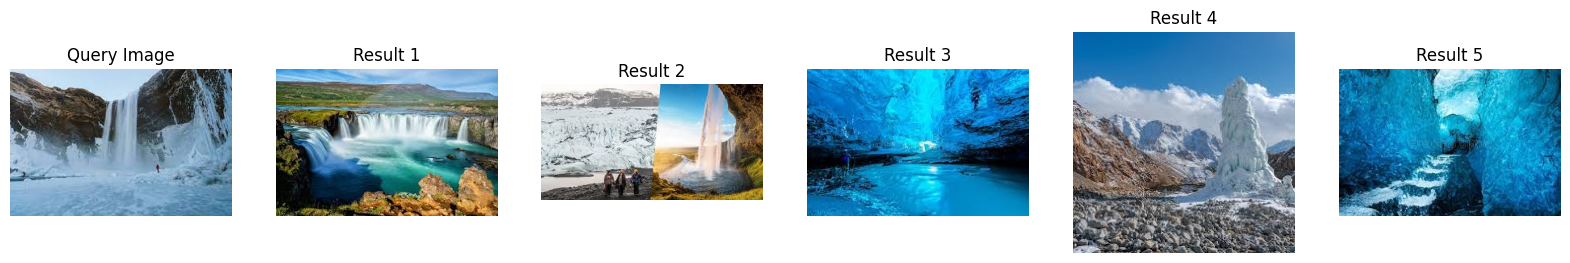

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
img_test = cv2.imread(path)
img_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Query Image')
for i, index in enumerate(indices.tolist()[0]):
    plt.subplot(1, 6, i+2)
    img = cv2.imread(paths[index])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Result {i+1}")

plt.show()